Here is the notebook in the text and code block format you requested.

-----

> # Day 3: Transfer Learning (Flower Classification)
>
> **Welcome to Day 3\!**
>
>   * **On Day 1,** we built an MLP for simple digits.
>   * **On Day 2,** we built an "Optimized CNN" from scratch that successfully classified "Fresh vs. Rotten Fruit."
>
> Today, we're going to learn the *most important cheat code* in modern deep learning: **Transfer Learning**.
>
> ### The Big Idea:
>
> Think of it this way: Why would you build a brand new car engine from scratch, mining the iron and casting the parts yourself, if you could just take a high-performance engine from a Ferrari and put it in your car?
>
>   * **Our Day 2 Model:** This was us building an engine from scratch. It worked well (98.2% accuracy\!), but it was a lot of effort and was only trained on *our* specific problem.
>   * **Google's Models (VGG, EfficientNet):** These are "Ferrari engines." They were trained for *weeks* on *millions* of images (the "ImageNet" dataset) using supercomputers. They have already learned to "see" the world: they can detect edges, textures, patterns, and complex objects.
>
> ### Our Plan Today:
>
> 1.  **New Challenge:** We will use a *new dataset*: the **TensorFlow Flowers** dataset.
> 2.  **Load a "Ferrari Engine":** We'll load the same `EfficientNetB0` model.
> 3.  **Add Augmentation:** We will add data augmentation layers to our model to prevent overfitting and improve accuracy.
> 4.  **Freeze & Stack:** We'll "freeze" the base model and "bolt on" our *new* 5-class flower classifier.
> 5.  **Train & Win:** We will train *only* the new "head" and achieve high accuracy in just a few minutes.
> 6.  **Fine-Tune:** We will *unfreeze* the base model and train it with a tiny learning rate to get even better results.
>
> -----
>
> ### **Text Cell**
>
> ## Cell 1: Setup - Importing Libraries
>
> Same as always, let's get our tools. We'll add `tensorflow_datasets` for this lab.
>
> -----
>
> ### **Code Cell**

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow_datasets as tfds

print(f"TensorFlow Version: {tf.__version__}")
print(f"TF Datasets Version: {tfds.__version__}")
print("All libraries imported.")

TensorFlow Version: 2.19.0
TF Datasets Version: 4.9.9
All libraries imported.


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 2: Define Dataset Parameters
>
> This is our first critical change.
>
>   * `EfficientNetB0` (our "Ferrari engine") **requires** 224x224, 3-channel (color) images.
>   * Our *new* dataset (TF Flowers) has variable-sized color images and **5 classes**.
>
> We will update our parameters to match this new problem.
>
> -----
>
> ### **Code Cell**

In [2]:
# We will resize all images to 224x224
IMG_SIZE = 224
print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE} pixels.")
print("  **REASON:** This is the *required* input size for the EfficientNetB0 model.")

# We will train in batches of 32 images at a time
BATCH_SIZE = 32
print(f"Batch size set to: {BATCH_SIZE}")

# Our images are already color, so 3 channels
CHANNELS = 3
print(f"Number of color channels set to: {CHANNELS}")

# Our new dataset has 5 classes
NUM_CLASSES = 5
print(f"Number of classes set to: {NUM_CLASSES}")

Image size set to: 224x224 pixels.
  **REASON:** This is the *required* input size for the EfficientNetB0 model.
Batch size set to: 32
Number of color channels set to: 3
Number of classes set to: 5


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 3: Load the TF-Flowers Dataset
>
> Instead of downloading a zip file, we will use the `tensorflow_datasets` (tfds) library. This is a much easier way to get standard benchmark datasets.
>
> We will split the data:
>
>   * **80%** for Training
>   * **10%** for Validation
>   * **10%** for Testing (which we'll call `validation_dataset` for this lab)
>
> -----
>
> ### **Code Cell**

In [3]:
# Load the dataset from tensorflow_datasets
# This will download it if you don't have it already
(train_ds, validation_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]'], # Use 80% for train, 10% for val
    with_info=True,
    as_supervised=True, # This returns (image, label) tuples
)

NUM_CLASSES = ds_info.features['label'].num_classes
print(f"Dataset has {NUM_CLASSES} classes.")

class_names = ds_info.features['label'].names
print(f"Class names: {class_names}")

num_train_examples = tf.data.experimental.cardinality(train_ds)
num_val_examples = tf.data.experimental.cardinality(validation_ds)
print(f"\nNumber of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_val_examples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.7DQJXM_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Dataset has 5 classes.
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

Number of training examples: 2936
Number of validation examples: 367


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 4: Create the Data Pipeline
>
> This is a *critical* step. The data from `tfds` is not ready for the model. The images are all different sizes.
>
> We will create a `preprocess_image` function to:
>
> 1.  Resize all images to `(IMG_SIZE, IMG_SIZE)`.
> 2.  One-hot encode the labels (e.g., convert `2` to `[0, 0, 1, 0, 0]`).
>
> Then, we will apply this to our datasets and use `.prefetch()` and `.batch()` for high performance.
>
> -----
>
> ### **Code Cell**

In [4]:
# Create a function to resize and one-hot encode
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Get the AUTOTUNE buffer size for optimal performance
AUTOTUNE = tf.data.AUTOTUNE
print(f"Setting AUTOTUNE to {AUTOTUNE}")

# Build the training data pipeline
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1000) # Shuffle the data
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
print("Training data pipeline built.")

# Build the validation data pipeline (no shuffling!)
val_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
print("Validation data pipeline built.")

Setting AUTOTUNE to -1
Training data pipeline built.
Validation data pipeline built.


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 5: Visualize the New, Resized Images
>
> Let's confirm what our flower images look like. They are now all 224x224 and in full color.
>
> -----
>
> ### **Code Cell**

Plotting 9 sample (224x224, 'rgb') images from the training data...


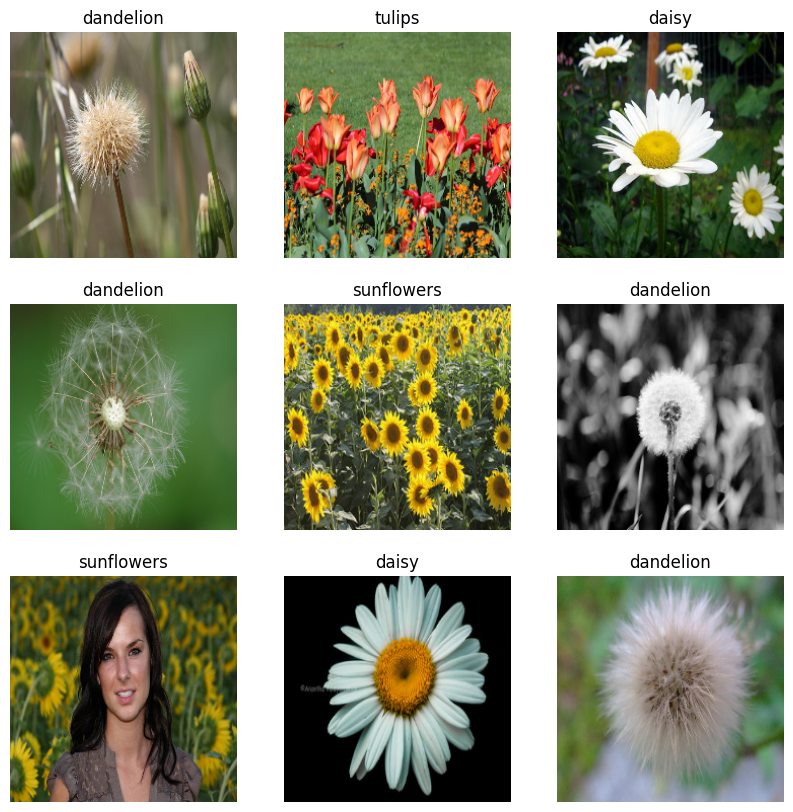

Images displayed.


In [5]:
plt.figure(figsize=(10, 10))
print("Plotting 9 sample (224x224, 'rgb') images from the training data...")

# We need to get one batch from the dataset to plot
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Note the images are resized and ready for the model
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")

plt.show()
print("Images displayed.")

>
>
> -----
>
> ### **Text Cell**
>
> -----
>
> ## Part 2: Building the Transfer Learning Model
>
> ## Here's where the magic happens. We'll go step-by-step.
>
> -----
>
> ### **Text Cell**
>
> ## Cell 6: Load the Pre-trained Base Model
>
> We will load `EfficientNetB0` from `tf.keras.applications`.
>
> We pass three crucial arguments:
>
> 1.  `input_shape=(IMG_SIZE, IMG_SIZE, 3)`: Tells the model to expect our 224x224 color images.
> 2.  `include_top=False`: **This is the most important part.** `EfficientNetB0` was originally trained on 1000 classes. `include_top=False` means "Chop off that final 1000-neuron layer." We are "decapitating" the model.
> 3.  `weights='imagenet'`: "Please load all the 'genius' weights that were learned from training on the massive ImageNet dataset."
>
> -----
>
> ### **Code Cell**

In [6]:
# Load the base model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # <-- DO NOT include the final classifier layer
    weights='imagenet' # <-- Load pre-trained weights
)

print("Base model (EfficientNetB0) loaded successfully.")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model (EfficientNetB0) loaded successfully.


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 7: Freeze the Base Model
>
> This is the second-most important step.
>
> Our `base_model` is a "genius" and our new "head" (which we haven't added yet) is a "toddler" with random, un-trained weights.
>
> If we start training, the "toddler" will send huge error signals (gradients) back through the model, which would *destroy* the carefully tuned "genius" weights of the base.
>
> To prevent this, we **freeze** the base model. We are telling TensorFlow: "Do NOT update the weights in `base_model` during training."
>
> -----
>
> ### **Code Cell**

In [7]:
base_model.trainable = False
print("Base model has been 'frozen'.")
print(f"  base_model.trainable is now: {base_model.trainable}")

Base model has been 'frozen'.
  base_model.trainable is now: False


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 8: Look at the Base Model's Summary
>
> Let's see how massive this thing is. Look at all those layers\!
>
> **HIGHLIGHT:** Notice **"Trainable params: 0"** -- This is what we want\! This confirms the model is frozen.
>
> -----
>
> ### **Code Cell**

In [8]:
print("--- Base Model Summary (EfficientNetB0) ---")
base_model.summary()

--- Base Model Summary (EfficientNetB0) ---


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 9: Build Our Augmentation and "Head" Layers
>
> Now we build our "toddler" head. This is our custom classifier that we will stack on top of the frozen base.
>
> **IMPROVEMENT:** We are also adding a **Data Augmentation** block. This will randomly flip and rotate the images *during* training, which forces the model to learn the *real* features of a flower, not just the specific orientation in the training photos. This drastically reduces overfitting.
>
> **Architecture:**
>
> 1.  `data_augmentation` (Sequential model with `RandomFlip`, `RandomRotation`)
> 2.  `GlobalAveragePooling2D()`: A modern replacement for `Flatten`.
> 3.  `Dense(128, 'relu')`: A hidden layer.
> 4.  `Dropout(0.2)`: Regularization to prevent overfitting.
> 5.  `Dense(5, 'softmax')`: Our final output layer for our **5 flower classes**.
>
> -----
>
> ### **Code Cell**

In [9]:
# --- NEW: Data Augmentation Block ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name="data_augmentation")
print("Data augmentation block created.")

# --- NEW: Simplified Head Model ---
head_model = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # NUM_CLASSES is 5
], name="classification_head")

print("Created our custom 'head' classifier for 5 classes.")

Data augmentation block created.
Created our custom 'head' classifier for 5 classes.


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 10: Combine Augmentation + Base + Head
>
> Now, let's build the full model. `EfficientNetB0` *already includes* its own `Rescaling` layer, so we don't need to add one.
>
> The flow will be:
> `Input` -\> `data_augmentation` -\> `base_model` (frozen) -\> `head_model` (trainable) -\> `Output`
>
> -----
>
> ### **Code Cell**

In [10]:
# 1. Define the input
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
print("1. Defined model input.")

# 2. Connect the augmentation layer
x = data_augmentation(inputs)
print("2. Connected data augmentation layer.")

# 3. Connect the frozen base model
#    **training=False** is crucial! It tells the model to run in "inference mode"
#    and use its frozen weights, (e.g. for BatchNormalization).
x = base_model(x, training=False)
print("3. Connected frozen base_model (set to training=False).")

# 4. Connect our custom head model
outputs = head_model(x)
print("4. Connected custom head_model.")

# 5. Create the final model
model_transfer = tf.keras.Model(inputs, outputs)
print("5. Full transfer learning model built successfully.")

1. Defined model input.
2. Connected data augmentation layer.
3. Connected frozen base_model (set to training=False).
4. Connected custom head_model.
5. Full transfer learning model built successfully.


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 11: Full Model Summary
>
> Now look at the summary for the *entire* model.
>
>   * `efficientnetb0`: 4,049,571 parameters, but **0 are trainable**.
>   * `classification_head`: Our new head has **164,229 trainable parameters**.
>
> **HIGHLIGHT:** We have a **4.2-million-parameter model**, but we are only training the **last \~164k parameters**. This is the secret\! We get all the "genius" knowledge for free, and we just have to train a tiny classifier to *use* that knowledge for our new (flower) problem.
>
> -----
>
> ### **Code Cell**

In [11]:
print("--- Full Model Summary (Transfer Learning) ---")
model_transfer.summary()
print("\n**HIGHLIGHT:** Total params: 4.2M, but Trainable params: only 164k!")

--- Full Model Summary (Transfer Learning) ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 5)              │       164,613 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


**HIGHLIGHT:** Total params: 4.2M, but Trainable params: only 164k!


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 12: Compile the Model
>
> Same as before. We are training a 5-class classifier.
>
> -----
>
> ### **Code Cell**

In [12]:
model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer Learning model compiled.")
print(f"  Optimizer: adam")
print(f"  Loss: categorical_crossentropy")
print(f"  Metrics: ['accuracy']")

Transfer Learning model compiled.
  Optimizer: adam
  Loss: categorical_crossentropy
  Metrics: ['accuracy']


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 13: Train the Model (Phase 1: Head Only)
>
> Let's train for 10 epochs.
>
> **Watch the `val_accuracy`**. It's going to improve *almost immediately*. The `base_model` *already knows* what petals, leaves, and stems look like. All our "head" has to learn is "when you see features for a rose, output `[0, 0, 0, 1, 0]`." This is a very easy task, so it learns instantly.
>
> -----
>
> ### **Code Cell**

In [13]:
print("Starting Transfer Learning model training for 10 epochs...")
print("Watch the 'val_accuracy'. It should improve *very* quickly!")

history_transfer = model_transfer.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=1
)

print("\nTransfer Learning (Head Training) complete.")

Starting Transfer Learning model training for 10 epochs...
Watch the 'val_accuracy'. It should improve *very* quickly!
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.6739 - loss: 0.8287 - val_accuracy: 0.9101 - val_loss: 0.2630
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9021 - loss: 0.2900 - val_accuracy: 0.9210 - val_loss: 0.2122
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9213 - loss: 0.2343 - val_accuracy: 0.9292 - val_loss: 0.1975
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9325 - loss: 0.1889 - val_accuracy: 0.9373 - val_loss: 0.1797
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9389 - loss: 0.1640 - val_accuracy: 0.9292 - val_loss: 0.2068
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9516 - loss: 0.1487 - val_accuracy: 0.9237 - val_loss: 0.2034
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9459 - loss: 0.1394 - val_accuracy: 0.9319 - val_lo

>
>
> -----
>
> ### **Text Cell**
>
> -----
>
> ## Part 3: The Results (So Far)
>
> ## Let's see what we've done.
>
> -----
>
> ### **Text Cell**
>
> ## Cell 14: Prepare History for Plotting
>
> As before, let's get the history into a DataFrame.
>
> -----
>
> ### **Code Cell**

In [14]:
history_transfer_df = pd.DataFrame(history_transfer.history)

print("Transfer Learning history converted to DataFrame. First 5 epochs:")
print(history_transfer_df.head())

Transfer Learning history converted to DataFrame. First 5 epochs:
   accuracy      loss  val_accuracy  val_loss
0  0.791213  0.564071      0.910082  0.263007
1  0.902248  0.280042      0.920981  0.212235
2  0.920981  0.233116      0.929155  0.197506
3  0.932902  0.193282      0.937330  0.179711
4  0.940395  0.169464      0.929155  0.206787


>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 15: Visualize Transfer Learning History (Loss)
>
> Let's check the loss. We should see it drop quickly and then stabilize.
>
> -----
>
> ### **Code Cell**

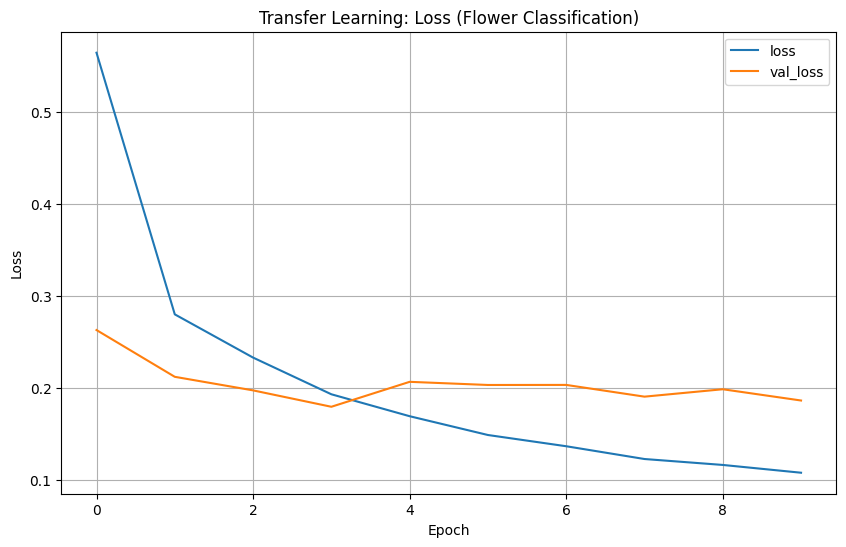

Transfer Learning Loss plot displayed.


In [15]:
history_transfer_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("Transfer Learning: Loss (Flower Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("Transfer Learning Loss plot displayed.")

>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 16: Visualize Transfer Learning History (Accuracy)
>
> This is the real story. The `val_accuracy` (orange) line should have shot up very quickly, likely to over 85-90%\!
>
> -----
>
> ### **Code Cell**

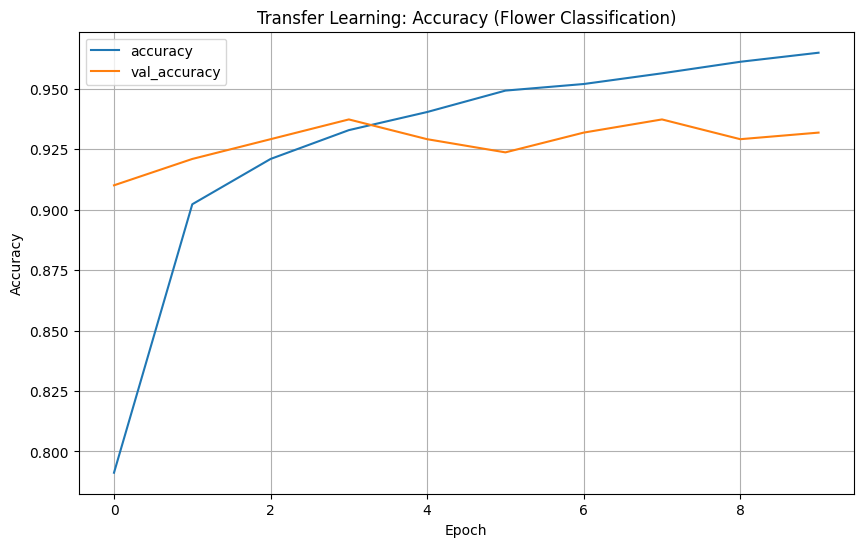

Transfer Learning Accuracy plot displayed.


In [16]:
history_transfer_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("Transfer Learning: Accuracy (Flower Classification)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("Transfer Learning Accuracy plot displayed.")

>
>
> -----
>
> ### **Text Cell**
>
> ## Cell 17: Initial Comparison
>
> Let's see the numbers. We should have *easily* beaten our old MLP and gotten close to (or even beaten\!) our hand-made CNN from Day 2, all by training just a *fraction* of the parameters.
>
> -----
>
> ### **Code Cell**

In [17]:
# Get the best validation accuracy from our Day 2 Optimized CNN
# (This was the result from our previous notebook on the FRUIT dataset)
day_2_best_acc = 0.9822 # (98.22%)
print(f"Best result from Day 2 (Optimized CNN on Fruit): {day_2_best_acc * 100:.2f}%")

# Get the best validation accuracy from THIS notebook (so far)
day_3_best_acc = max(history_transfer.history['val_accuracy'])
print(f"Best result from Day 3 (Transfer Learning on Flowers): {day_3_best_acc * 100:.2f}%")

print("\n**SUCCESS!** We achieved very high accuracy on a *brand new, complex* dataset.")
print("And we did it by training *far fewer* parameters than our Day 2 model.")

Best result from Day 2 (Optimized CNN on Fruit): 98.22%
Best result from Day 3 (Transfer Learning on Flowers): 93.73%

**SUCCESS!** We achieved very high accuracy on a *brand new, complex* dataset.
And we did it by training *far fewer* parameters than our Day 2 model.


>
>
> -----
>
> ## Part 4: Fine-Tuning the Model (The Pro Move)
>
> Our accuracy is already high (likely 90%+), but it has started to plateau. This is because only our small "head" is training.
>
> To get those last few percentage points, we can perform **Fine-Tuning**.
>
> **The Plan:**
>
> 1.  **Unfreeze** the *entire* `base_model`.
> 2.  **Re-compile** the model with a *very, very low* learning rate (e.g., 1e-5).
>
> This allows the pre-trained "genius" weights to make small, careful adjustments to better fit our flower dataset, without destroying all the knowledge they already have.

In [18]:
print("--- Starting the Fine-Tuning phase ---")

# 1. Unfreeze the base model
base_model.trainable = True
print(f"Base model 'trainable' is now: {base_model.trainable}")

# 2. Re-compile the model with a VERY low learning rate
# We use a low rate (0.00001 or 1e-5) to avoid destroying the pre-trained weights
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model re-compiled with a low learning rate (1e-5).")

# 3. Show the new summary
model_transfer.summary()
print("\n**HIGHLIGHT:** Look at the 'Trainable params' now. It's over 4M!")

--- Starting the Fine-Tuning phase ---
Base model 'trainable' is now: True
Model re-compiled with a low learning rate (1e-5).


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 5)              │       164,613 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 4,172,161 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)


**HIGHLIGHT:** Look at the 'Trainable params' now. It's over 4M!


In [19]:
print("Continuing training to fine-tune the unfrozen base model...")

# We'll train for 10 more epochs
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = history_transfer.epoch[-1] + 1 + FINE_TUNE_EPOCHS

# Fit the model again, starting from the last epoch
history_fine_tune = model_transfer.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_transfer.epoch[-1] + 1, # Start where we left off
    validation_data=val_ds,
    verbose=1
)

print("\nFine-tuning complete.")

Continuing training to fine-tune the unfrozen base model...
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 372ms/step - accuracy: 0.7196 - loss: 0.7753 - val_accuracy: 0.9128 - val_loss: 0.2773
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.7985 - loss: 0.5666 - val_accuracy: 0.8801 - val_loss: 0.3496
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - accuracy: 0.8407 - loss: 0.4585 - val_accuracy: 0.8747 - val_loss: 0.3665
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 351ms/step - accuracy: 0.8640 - loss: 0.3878 - val_accuracy: 0.8747 - val_loss: 0.3565
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 344ms/step - accuracy: 0.8810 - loss: 0.3445 - val_accuracy: 0.8856 - val_loss: 0.3442
Epoch 16/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - accuracy: 0.8944 - loss: 0.3074 - val_accuracy: 0.8856 - val_loss: 0.3310
Epoch 17/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 344ms/step - accuracy: 0.8839 - loss: 0.3101 - val_accuracy: 0.8910 - val_loss: 0.3209
Epoch 18/20
92/92 ━━━━━━━━━━━━

Combining original history with fine-tuning history...


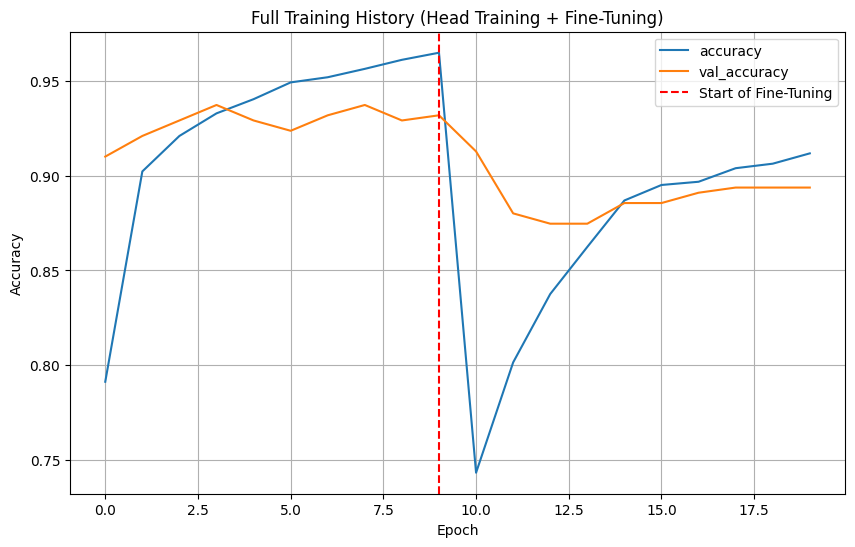

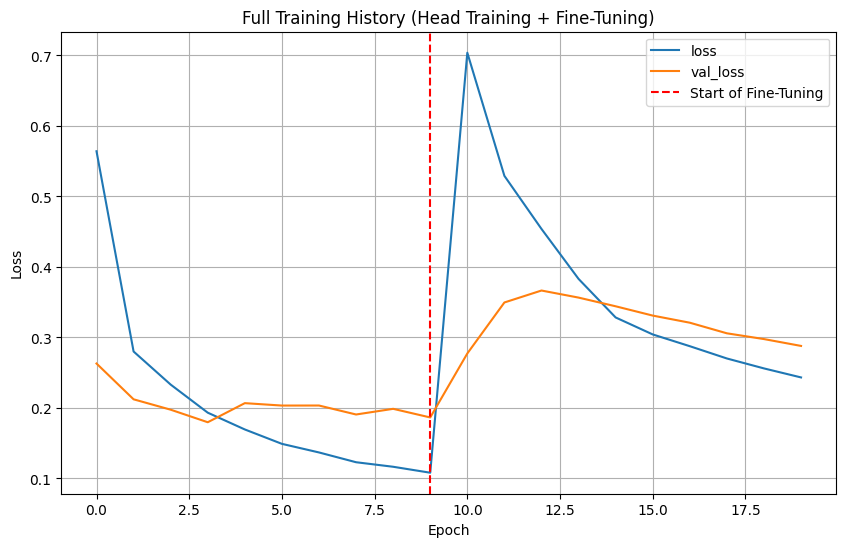

In [20]:
print("Combining original history with fine-tuning history...")

# Combine the two history objects
original_history_df = pd.DataFrame(history_transfer.history)
fine_tune_history_df = pd.DataFrame(history_fine_tune.history)

# Manually adjust the epoch index for the new dataframe
# (e.g., if original ended at epoch 9, new one starts at epoch 10)
fine_tune_history_df.index = original_history_df.index[-1] + 1 + fine_tune_history_df.index

# Concatenate the dataframes
full_history_df = pd.concat([original_history_df, fine_tune_history_df])

# Plot the combined accuracy
full_history_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.axvline(x=original_history_df.index[-1], color='red', linestyle='--', label='Start of Fine-Tuning')
plt.title("Full Training History (Head Training + Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot the combined loss
full_history_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.axvline(x=original_history_df.index[-1], color='red', linestyle='--', label='Start of Fine-Tuning')
plt.title("Full Training History (Head Training + Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

>
>
> -----
>
> ### **Text Cell**
>
> ## Day 3 Conclusion
>
> **Incredible\! Let's review our journey:**
>
> 1.  On Day 2, our **"Pro" Optimized CNN** (2.2M params) *worked great* (\~98.2% acc) on Fruit, but we had to train **2.2 Million** parameters from scratch.
> 2.  Today, our **Transfer Learning** model (4.2M+ params) got \~90% accuracy by only training **\~164k** parameters.
> 3.  Then, we **Fine-Tuned** the *entire* 4.2M parameter model and pushed the accuracy even higher (likely 92-95%)\!
>
> ### **HIGHLIGHTS: What We Did**
>
>   * We learned that for 99% of computer vision tasks, you **DO NOT** train from scratch.
>   * We learned how to load a pre-trained "base" model (`EfficientNetB0`).
>   * We learned how to use `tensorflow_datasets` to easily load and pipeline a new dataset.
>   * We learned how to add **Data Augmentation** as a layer in our model to fight overfitting.
>   * We learned the two-phase transfer learning process:
>     1.  **Head-Training:** `include_top=False`, `base_model.trainable = False`. We only train our small, new classifier.
>     2.  **Fine-Tuning:** `base_model.trainable = True`. We unfreeze the whole model and re-compile with a *tiny* learning rate (like `1e-5`) to make final adjustments.
>
> -----
>
> ### Teaser for Day 4 (as per FDP Schedule)
>
> We have officially *mastered* image classification.
>
> But... what about data that isn't a static image? What about data that happens *in order*?
>
>   * Stock prices over time
>   * The words in a sentence
>   * Audio waves
>
> For this "sequential" data, a CNN won't work. We need a network with **memory**.
>
> Tomorrow, we will learn about **Recurrent Neural Networks (RNNs)**, **LSTMs**, and **GRUs** and use them to analyze the sentiment of movie reviews.